# Simple MPC for a heat pump and hot water storage system

Below is a schematic of the system developed by GridWorks, and that is currently being installed in a house in Maine. The load in this case is space heating (not including domestic hot water) of the house.

![Setup](gridworks_setup.png)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import casadi
import os

## 1 - Estimating storage capacity

The system includes four water tanks of 450 L each. Setting a minimum water temperature $T_{min}$ defines the SoC of 0% at that temperature. From there we can estimate the storage capacity:

\begin{equation}
\text{Storage capactiy} = m \cdot c_p \cdot (T_{max}-T_{min}) \ [kWh]
\end{equation}

\begin{equation}
SoC(T) = \frac{T-T_{min}}{T_{max}-T_{min}} \ [\%]
\end{equation}

In [2]:
# The maximum storage capacity (kWh)
mass_of_water = 450*4 # 450kg water per tank
max_temp, min_temp = 65, 38 #°C
max_storage = mass_of_water * 4187 * (max_temp - min_temp) # in Joules
max_storage = round(max_storage * 2.77778e-7,1) # in kWh

print(f"The storage capacity is {max_storage} kWh.")

The storage capacity is 56.5 kWh.


In [3]:
# Allow colder water (35°C) as negative storage
min_storage = mass_of_water * 4187 * (35 - min_temp) # in Joules
min_storage = round(min_storage * 2.77778e-7,1) # in kWh
min_storage = 0
print(f"The min storage capacity is {min_storage} kWh.")

The min storage capacity is 0 kWh.


## 2 - Forecasts

The load is predicted on the outside air temperature. I didn't include the code for this here, but basically:
- The outside air temperature forecast is obtained from pvlib (the data here is for a day in Feb 2024 in Maine)
- The load is predicted based on the outside air temperature using random forests forecaster (from the fcLib library) with a yearly dataset of past data

In [4]:
# Outside air temperature [°C]
T_OA = [-12.52, -12.28, -12.55, -14.18, -13.76, -13.96, -14.26, -14.13, 
        -13.99, -9.65, -6.86, -5.21, -3.69, -2.88, -2.36, -2.29, -3.91, 
        -5.52, -6.13, -6.58, -7.09, -7.43, -7.99, -8.68] 
T_OA = [12]*24

# Load [kWh]
load = [8.12, 8.07, 8.13, 8.57, 8.46, 8.51, 8.59, 8.55, 8.52, 7.4, 
        6.69, 6.26, 5.87, 5.68, 5.52, 5.5, 5.92, 6.34, 6.49, 6.61, 6.74, 6.81, 6.94, 7.15] 
load = [5.117, 5.117, 5.117, 5.117, 5.117, 5.117, 4.652, 4.652, 3.722, 3.722, 3.722, 3.722, 
        3.722, 3.257, 3.257, 3.257, 3.257, 3.257, 4.187, 4.187, 4.652, 4.652, 5.117, 5.117]
#load = [2.326, 1.861, 1.861, 2.326, 2.326, 1.861, 1.861, 1.396, 0.93, 0.465, 0.465, 0.465, 
        #0.465, 0.465, 0.465, 0.465, 0.465, 0.465, 0.93, 0.93, 1.861, 1.861, 1.861, 2.326]

# To try variations of the load
# load = [x/2 for x in load]

The electricity prices come with three options, to test the system in different conditions.

In [5]:
# Electricity prices [cts/kWh]
price_type = "gridworks"

if price_type == "gridworks":
    c_el = [6.36, 6.34, 6.34, 6.37, 6.41, 6.46, 6.95, 41.51,
            41.16, 41.07, 41.06, 41.08, 7.16, 7.18, 7.18, 7.16, 41.2, 41.64,
            41.43, 41.51, 6.84, 6.65, 6.46, 6.4]

elif price_type == "progressive":
    c_el = [18.97, 18.92, 18.21, 16.58, 16.27, 15.49, 14.64,
            18.93, 45.56, 26.42, 18.0, 17.17, 16.19, 30.74, 31.17, 16.18,
            17.11, 20.24, 24.94, 24.69, 26.48, 30.15, 23.14, 24.11]

elif price_type == "peter":
    c_el = [0.07919, 0.066283, 0.063061, 0.067943, 0.080084, 0.115845, 
                0.193755, 0.215921, 0.110822, 0.044927, 0.01521, 0.00742, 
                0.004151, 0.007117, 0.009745, 0.02452, 0.037877, 0.09556, 
                0.205067, 0.282588, 0.234866, 0.184225, 0.132268, 0.101679]
    c_el = [x*100 for x in c_el]

## 3 - Estimating parameters from manufacturer data

Estimate maximum heating power that the heat pump can provide $\dot{Q}_{HP, max}$ and $1/COP$ depending on the outside air temperatue ($T_{OA}$). These approximations are based on regressions on data from the manufacturer's table. 

In [6]:
B0_Q, B1_Q = -68851.589, 313.3151
B0_C, B1_C = 2.695868, -0.008533

def Q_HP_max(T_OA):
    T_OA += 273
    return round((B0_Q + B1_Q*T_OA)/1000,2) if T_OA<273-7 else 14
    
def COP1(T_OA):
    T_OA += 273
    return round(B0_C + B1_C*T_OA,2)

Get the maximum heating power and 1/COP term for every hour in the forecast, based on outside air temperature.

In [7]:
# Q_HP_max forecast from T_OA [kWh_th]
Q_HP_max_list = [Q_HP_max(temp) for temp in T_OA]
Q_HP_min_list = [8 for x in Q_HP_max_list]

# 1/COP forecast from T_OA
COP1_list = [COP1(temp) for temp in T_OA]

## 4 - Problem overview plot

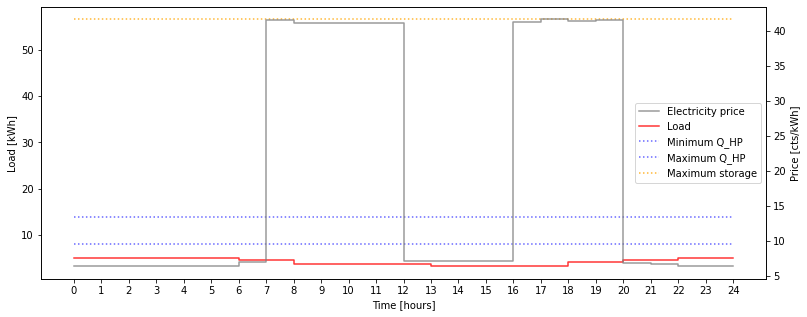

In [8]:
# Duplicate the last element of the hourly data for the plot
c_el2 = c_el + [c_el[-1]]
load2 = load + [load[-1]]
Q_min2 = Q_HP_min_list + [Q_HP_min_list[-1]]
Q_max2 = Q_HP_max_list + [Q_HP_max_list[-1]]

N = len(c_el)
fig, ax = plt.subplots(1,1, figsize=(13,5))
ax2 = ax.twinx()
ax2.step(range(N+1), c_el2, where='post', color='gray', alpha=0.8, label='Electricity price')
ax.step(range(N+1), load2, where='post', color='red', alpha=0.8, label='Load')
ax.step(range(N+1), Q_min2, where='post', color='blue', alpha=0.6, label='Minimum Q_HP', linestyle='dotted')
ax.step(range(N+1), Q_max2, where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
ax.step(range(N+1), [max_storage]*(N+1), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
ax.set_xticks(range(N+1))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Load [kWh]")
ax2.set_ylabel("Price [cts/kWh]")
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines2 + lines1, labels2 + labels1)
plt.show()

## 5 - Optimization problem (MILP)

This function defines the MILP which will be used for MPC. Time *t* is discretized in hours, with a horizon of N hours (t=0,...,N).

**Variables:**
- The state variables (t=0,...,N):
   - $storage(t)$: The energy in the storage (kWh)
- The input variables (t=0,...,N-1):
   -  $Q_{HP}(t)$: The heating power of the HP (kW, during one hour so also kWh)
   -  $\delta_{HP}(t)$: A binary variable that turns the HP on or off
   -  $Q_{HP,onoff}(t)$: This variable replaces the bilinear $Q_{HP} \cdot \delta_{HP}$ terms, in order to linearize the equations. The constraints force $Q_{HP,onoff}$ = $Q_{HP} \cdot \delta_{HP}$ without using non linearities.
 
**Constraints [LINEAR]:**
- Initial storage level
- Min/max storage, $Q_{HP}$, $\delta_{HP}$
- Constraints to replace the bilinear terms $Q_{HP} \cdot \delta_{HP}$ with a single variable
- System dynamics:

\begin{equation}
storage(t+1) = storage(t) + Q_{HP}(t) - load(t) 
\end{equation}

**Objective [LINEAR]:**

Minimize cost of electricity during next N steps. Note that $COP(t)$ and $c_{el}(t)$ are parameters so the objective is linear with respect to the optimization variables.

\begin{equation}
\min \sum_{t=0}^{N-1} \frac{Q_{HP,onoff}(t)}{COP(t)} \cdot c_{el}(t)
\end{equation}

In [9]:
def get_opti(N, c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list):

    # Initialize    
    opti = casadi.Opti('conic')

    # -----------------------------
    # Variables and solver
    # -----------------------------
    
    storage = opti.variable(1,N+1)  # state
    Q_HP = opti.variable(1,N)       # input
    delta_HP = opti.variable(1,N)  # input
    Q_HP_onoff = opti.variable(1,N) # input (derived)
    
    # delta_HP is a discrete variable (binary)
    discrete_var = [0]*(N+1) + [0]*N + [1]*N + [0]*N

    # Solver
    opti.solver('gurobi', {'discrete':discrete_var, 'gurobi.OutputFlag':0})

    # -----------------------------
    # Constraints
    # -----------------------------
    
    # Initial storage level
    opti.subject_to(storage[0] == storage_initial)

    # Constraints at every time step
    for t in range(N+1):

        # Bounds on storage
        opti.subject_to(storage[t] >= min_storage)
        opti.subject_to(storage[t] <= max_storage)

        if t < N:
            
            # System dynamics
            opti.subject_to(storage[t+1] == storage[t] + Q_HP_onoff[t] - load[t])
    
            # Bounds on delta_HP
            opti.subject_to(delta_HP[t] >= 0)
            opti.subject_to(delta_HP[t] <= 1)
        
            # Bounds on Q_HP
            opti.subject_to(Q_HP[t] <= Q_HP_max_list[t])    
            opti.subject_to(Q_HP[t] >= Q_HP_min_list[t]*delta_HP[t])
        
            # Bilinear to linear
            opti.subject_to(Q_HP_onoff[t] <= Q_HP_max_list[t]*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] >= Q_HP_min_list[t]*delta_HP[t])
            opti.subject_to(Q_HP_onoff[t] <= Q_HP[t] + Q_HP_min_list[t]*(delta_HP[t]-1))
            opti.subject_to(Q_HP_onoff[t] >= Q_HP[t] + Q_HP_max_list[t]*(delta_HP[t]-1))
    
    # -----------------------------
    # Objective
    # -----------------------------
    
    obj = sum(Q_HP_onoff[t]*c_el[t]*COP1_list[t] for t in range(N))
    opti.minimize(obj)

    # -----------------------------
    # Solve and get optimal values
    # -----------------------------
    
    sol = opti.solve()
    Q_opt = sol.value(Q_HP_onoff)
    stor_opt = sol.value(storage)
    HP_on_off_opt = sol.value(delta_HP)
    obj_opt = round(sol.value(obj)/100,2)

    return Q_opt, stor_opt, HP_on_off_opt, obj_opt

## 6 - Open-loop MPC, horizon 24 hours

Single iteration of MPC, with a horizon of 24 hours.

Academic license - for non-commercial use only
Academic license - for non-commercial use only


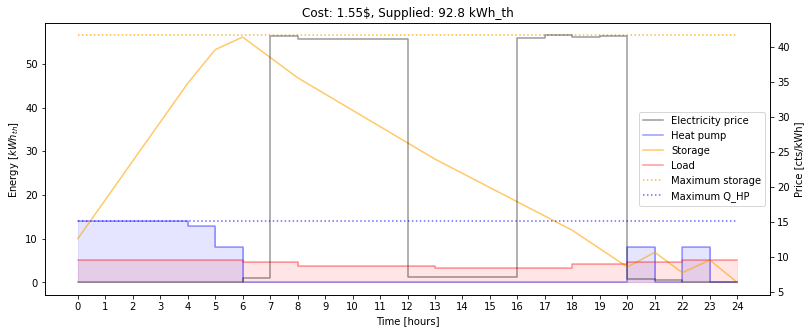

In [10]:
# Horizon
N = 24

# Get the solution from the optimization problem
storage_initial = 10
Q_opt, stor_opt, HP_on_off_opt, obj_opt \
= get_opti(N, c_el, load, max_storage, storage_initial, Q_HP_min_list, Q_HP_max_list)

# Duplicate the last element of the hourly data for the plot
c_el2 = c_el + [c_el[-1]]
Q_opt2 = [round(x,3) for x in Q_opt] + [Q_opt[-1]]
load2 = load + [load[-1]]

# Plot
fig, ax = plt.subplots(1,1, figsize=(13,5))
ax.step(range(N+1), Q_opt2, where='post', label='Heat pump', alpha=0.4, color='blue')
ax.plot(range(N+1), stor_opt, label='Storage', alpha=0.6, color='orange')
ax.step(range(N+1), load2, where='post', label='Load', alpha=0.4, color='red')
ax.step(range(N+1), [max_storage]*(N+1), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
ax.step(range(N+1), Q_max2, where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
ax.fill_between(range(N+1), load2, step="post", color='red', alpha=0.1)
ax.fill_between(range(N+1), Q_opt2, step="post", color='blue', alpha=0.1)
ax.set_xticks(range(N+1))
ax.set_xlabel("Time [hours]")
ax.set_ylabel("Energy [$kWh_{th}$]")
plt.title(f"Cost: {obj_opt}$, Supplied: {round(sum(Q_opt2),1)} kWh_th")
ax2 = ax.twinx()
ax2.set_ylabel("Price [cts/kWh]")
ax2.step(range(N+1), c_el2, where='post', label='Electricity price', color='black', alpha = 0.4)
lines1, labels1 = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines2 + lines1, labels2 + labels1)
plt.show()

The blue area is the heat supplied by the heat pump. The red area is the heating demand (the load). Clearly the system is able to decouple the times at which the heat is supplied and the ones at which the heat is demanded, turning on the heat pump during the cheapest hours of the day and discharging the storage during the most expensive ones.

## 7 - Closed-loop MPC, horizon N hours

Iterating on the previous method every time step (hour) gives closed-loop MPC. Here we choose a horizon of N hours for each iteration.

In [11]:
# Duplicate forecasts to allow for longer simulations
c_el = c_el*20
load = load*20
Q_HP_max_list = Q_HP_max_list*20
Q_HP_min_list = Q_HP_min_list*20
COP1_list = COP1_list*20

def closed_loop_MPC(N):

    # 24 hour simulation
    num_iterations = 24

    initial_storage = 0
    Q_opt_overall, stor_opt_overall, operating_hours_overall = [], [], []
    cost_total = 0
    
    # Add the receiding horizon, 8 hour horizon
    for iter in range(num_iterations):
    
        # Update forecasts for new interation
        c_el_current = c_el[iter:iter+N]
        load_current = load[iter:iter+N]
        Q_HP_min_list_current = Q_HP_min_list[iter:iter+N]
        Q_HP_max_list_current = Q_HP_max_list[iter:iter+N]
    
        # Get optimal solution for next N steps
        Q_opt, stor_opt, HP_on_off_opt, obj_opt = \
        get_opti(N, c_el_current, load_current, max_storage, initial_storage, Q_HP_min_list_current, Q_HP_max_list_current)
    
        # Next state of the system
        initial_storage = stor_opt[1]
    
        # Apprend what you did in this hour
        Q_opt_overall.append(Q_opt[0])
        stor_opt_overall.append(stor_opt[0])
        operating_hours_overall.append(1 if HP_on_off_opt[0]==1 else 0)
        cost_total += (Q_opt[0] * c_el_current[0])*COP1(T_OA[iter])/100
        
        # Duplicate the last element of the hourly data for the plot
        c_el2 = c_el_current + [c_el_current[-1]]
        Q_opt2 = [round(x,3) for x in Q_opt] + [Q_opt[-1]]
        load2 = load_current + [load_current[-1]]
        
        # To plot each iteration (open loop results)
        plot_each_iteration = False
        if plot_each_iteration:
            fig, ax = plt.subplots(1,1, figsize=(13,5))
            ax.step(range(N+1), Q_opt2, where='post', label='Heat pump', alpha=0.4, color='blue')
            ax.plot(range(N+1), stor_opt, label='Storage', alpha=0.6, color='orange')
            ax.step(range(N+1), load2, where='post', label='Load', alpha=0.4, color='red')
            ax.set_xticks(range(N+1))
            ax.set_xlabel("Time [hours]")
            ax.set_ylabel("Energy [$kWh_{th}$]")
            plt.title(f"Cost: {obj_opt}$, Supplied: {round(sum(load),1)} kWh_th \n=> {round(100*obj_opt/sum(load),2)} cts/kWh_th")
            ax2 = ax.twinx()
            ax2.set_ylabel("Price [cts/kWh]")
            ax2.step(range(N+1), c_el2, where='post', label='Electricity price', color='black', alpha = 0.4)
            lines1, labels1 = ax.get_legend_handles_labels()
            lines2, labels2 = ax2.get_legend_handles_labels()
            ax.legend(lines2 + lines1, labels2 + labels1)
            plt.show()
    
    # Plot closed-loop result
    fig, ax = plt.subplots(1,1, figsize=(13,5))
    ax.step(range(num_iterations), Q_opt_overall, where='post', label='Heat pump', alpha=0.4, color='blue')
    ax.step(range(num_iterations), load[:num_iterations], where='post', label='Load', alpha=0.4, color='red')
    ax.plot(range(num_iterations), stor_opt_overall, label='Storage', alpha=0.6, color='orange')
    ax.step(range(num_iterations), Q_max2[:num_iterations], where='post', color='blue', alpha=0.6, label='Maximum Q_HP', linestyle='dotted')
    ax.step(range(num_iterations), [max_storage]*(num_iterations), where='post', color='orange', alpha=0.8, label='Maximum storage', linestyle='dotted')
    ax.fill_between(range(num_iterations), load[:num_iterations], step="post", color='red', alpha=0.1)
    ax.fill_between(range(num_iterations), Q_opt_overall, step="post", color='blue', alpha=0.1)
    ax.set_xticks(range(num_iterations))
    ax.set_xlabel("Time [hours]")
    ax.set_ylabel("Energy [$kWh_{th}$]")
    ax2 = ax.twinx()
    ax2.set_ylabel("Price [cts/kWh]")
    ax2.step(range(num_iterations), c_el[:num_iterations], where='post', label='Electricity price', color='black', alpha = 0.4)
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines2 + lines1, labels2 + labels1)
    plt.title(f"Cost: {round(cost_total,1)}$, Supplied: {round(sum(Q_opt_overall),1)} kWh_th")
    plt.show()

    return operating_hours_overall

The reason why the storage is not empty at the end of the 24-hour simulation is not because the solution is suboptimal, but because the system is anticipating the hours to come after the 24 hours.

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

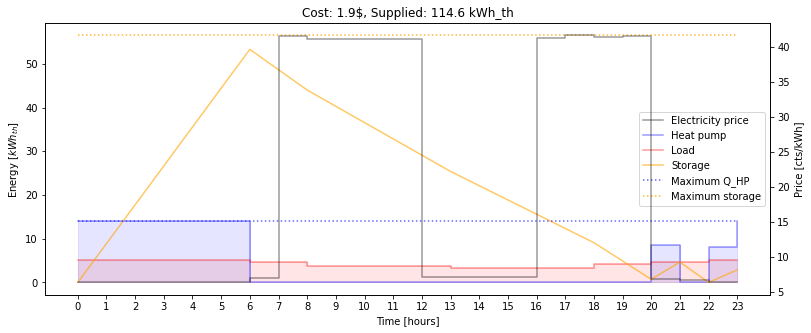

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1]

In [12]:
closed_loop_MPC(24)

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic lice

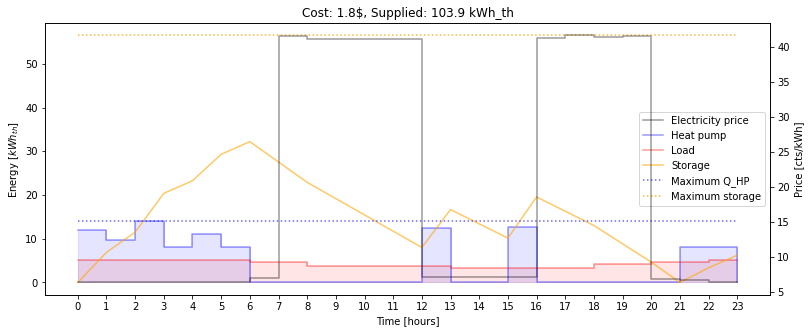

[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0]

In [13]:
closed_loop_MPC(8)